# Magnetic Levitation Useful Functions + Calculations
- Jeff

## The calculations in this notebook are off. They show the correct qualitative behavior, but I think I wrote the magnetic field solution incorrectly. If you need maglev calculations use the "farDetunedLatticeWithMaglev.ipynb" notebook

Deprecated: Small notebook to calculate the B field necessary to increase the trap depth during optical transport by a certain temperature using magnetic levitation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from tqdm import tqdm

import arc

from get_polarizability import *


In [20]:
# constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K
mu0 = 1.25663706127e-6 # Permeability of free space in SI units
muB = 9.2740100657e-24 # Bohr magneton in J/T

# Cs information
Cs_D1_wavelength = 894.592959e-9  # Cs D1 line wavelength in meters
Cs_D1_frequency = c / Cs_D1_wavelength  # Cs D1 line frequency in Hz
Cs_D1_gamma = 4.5612e6 # Cs D1 line natural linewidth in Hz
Cs_D1_pi_Isat = 2.4981*10  # Cs D1 line pi-polarized saturation intensity in W/m^2

Cs_D2_wavelength = 852.34727582e-9  # Cs D2 line wavelength in meters
Cs_D2_frequency = c / Cs_D2_wavelength  # Cs D2 line frequency in Hz
Cs_D2_gamma = 5.2227e6 # Cs D2 line natural linewidth in Hz
Cs_D2_pi_Isat = 1.6536*10  # Cs D2 line pi-polarized saturation intensity in W/m^2
Cs_D2_iso_Isat = 2.7059*10  # Cs D2 line isotropic saturation intensity in W/m^2
Cs_D2_sigma_Isat = 1.1023*10  # Cs D2 line sigma-polarized saturation intensity in W/m^2

# Rb information
Rb_D1_wavelength = 794.978850e-9      # Rb D1 line wavelength in meters
Rb_D1_frequency = c / Rb_D1_wavelength  # Rb D1 line frequency in Hz
Rb_D1_gamma = 5.746e6 # Rb D1 line natural linewidth in Hz
Rb_D1_pi_Isat = 4.484*10  # Rb D1 line pi-polarized saturation intensity in W/m^2

Rb_D2_wavelength = 780.241209686e-9  # Rb D2 line wavelength in meters
Rb_D2_frequency = c / Rb_D2_wavelength  # Rb D2 line frequency in Hz
Rb_D2_gamma = 6.065e6 # Rb D2 line natural linewidth in Hz
Rb_D2_pi_Isat = 2.503*10  # Rb D2 line pi-polarized saturation intensity in W/m^2
Rb_D2_iso_Isat = 3.576*10  # Rb D2 line isotropic saturation intensity in W/m^2
Rb_D2_sigma_Isat = 1.669*10  # Rb D2 line sigma-polarized saturation intensity in W/m^2

## Naive Calculation

In [21]:
def lande_gF(F, J, I, gJ, gI, muN_over_muB=1/1836.15267389):
    """
    Calculate the hyperfine Landé g_F factor for an atom in the weak-field (linear Zeeman) regime.
    
    Parameters
    ----------
    F : float
        Total hyperfine quantum number (can be integer or half-integer).
    J : float
        Total electronic angular momentum quantum number.
    I : float
        Nuclear spin quantum number.
    gJ : float
        Electronic Landé g-factor (dimensionless).
    gI : float, optional
        Nuclear g-factor (dimensionless). Default 0 (neglect nuclear contribution).
    muN_over_muB : float, optional
        Ratio mu_N / mu_B (nuclear magneton over Bohr magneton). Default ~ 1/1836.15267389.
    
    Returns
    -------
    gF : float
        The Landé g-factor for the hyperfine level F.
    
    Formula
    -------
    g_F = g_J * [F(F+1) + J(J+1) - I(I+1)] / [2 F(F+1)]
          + g_I * (mu_N/mu_B) * [F(F+1) + I(I+1) - J(J+1)] / [2 F(F+1)]
    """
    num1 = F*(F+1) + J*(J+1) - I*(I+1)
    num2 = F*(F+1) + I*(I+1) - J*(J+1)
    den = 2*F*(F+1)
    gF = gJ * (num1/den) + gI * muN_over_muB * (num2/den)
    return gF

def lande_gJ(L, S, J, gL=1.0, gS=2.0023193043737):
    return (gL * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1))
          + gS * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1)))


In [22]:
# Cesium 133 in F=3, mF=-1 sublevel, worst case scenario for maglev
m = 133 * 1.66054e-27
g = 9.8

##### Axial (along x) displacement, (z=0) #####
# MOT coil parameters, copying 2.0's numbers
N = 18 # 18 turns per coil
R = 68.326e-3/2 # Inner radius
s = 53e-3/2 # 53 mm between coils along coil axis

# Atom choice
atom = arc.Caesium()   # pick an atom
n = 6
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 3 # Choose F=3 manifold
mF = 3

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF = lande_gF(F, J, I, gJ, gI)

# Necessary field gradient
dBdz = (m*g)/(gF*mF*muB)
print(f"Necessary field gradient = {dBdz*1e2} Gauss/cm")

I = (2*dBdz*(R**2 + s**2)**(5/2)) / (3*mu0*N*(R**2)*s)
print(f"Necessary current: {I} A")

Necessary field gradient = -31.080963200151917 Gauss/cm
Necessary current: -44.750269953617014 A


In [23]:
# Rb87 in F=1, mF=1
m = 87 * 1.66054e-27
g = 9.8

##### Axial (along x) displacement, (z=0) #####
# MOT coil parameters, copying 2.0's numbers
N = 18 # 18 turns per coil
R = 68.326e-3/2 # Inner radius
s = 53e-3/2 # 53 mm between coils along coil axis

# Atom choice
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 1
mF = 1

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF = lande_gF(F, J, I, gJ, gI)

# Necessary field gradient
dBdz = (m*g)/(gF*mF*muB)
print(f"Necessary field gradient = {dBdz*1e2} Gauss/cm")

I = (2*dBdz*(R**2 + s**2)**(5/2)) / (3*mu0*N*(R**2)*s)
print(f"Necessary current: {I} A")

Necessary field gradient = -30.496723071674726 Gauss/cm
Necessary current: -43.9090829125744 A


# Full Field Simulations w/ J AntiHelmholz

In [49]:
def loop_field_cylindrical(rho, z, R, N, I, z0=0.0, mu0=mu0):
    """
    Magnetic field of a single circular loop in cylindrical coords (rho,z),
    using complete elliptic integrals (SciPy).

    Returns Brho, Bz in Tesla.

    Notes
    -----
    Uses the standard closed-form expressions involving K(m) and E(m),
    where m = k^2 = 4 R rho / ((R+rho)^2 + (z-z0)^2).
    """
    rho = np.asarray(rho, dtype=float)
    z = np.asarray(z, dtype=float)
    dz = z - z0

    # Broadcast to common shape
    rho, dz = np.broadcast_arrays(rho, dz)

    Brho = np.zeros_like(rho, dtype=float)
    Bz = np.zeros_like(rho, dtype=float)

    on_axis = np.isclose(rho, 0.0)

    # On-axis: simple formula
    if np.any(on_axis):
        dz0 = dz[on_axis]
        Bz[on_axis] = (mu0 * N * I * R**2) / (2.0 * (R**2 + dz0**2)**1.5)
        Brho[on_axis] = 0.0

    # Off-axis: elliptic integral formula
    off = ~on_axis
    if np.any(off):
        r = rho[off]
        zz = dz[off]

        alpha2 = (R + r)**2 + zz**2
        beta2  = (R - r)**2 + zz**2
        m = 4.0 * R * r / alpha2  # parameter m=k^2

        K = special.ellipk(m)
        E = special.ellipe(m)

        alpha = np.sqrt(alpha2)
        pref = mu0 * N * I / (2.0 * np.pi)

        Bz_off = pref * (1.0 / alpha) * (
            K + (R**2 - r**2 - zz**2) / beta2 * E
        )

        Br_off = pref * (zz / (r * alpha)) * (
            -K + (R**2 + r**2 + zz**2) / beta2 * E
        )

        Bz[off] = Bz_off
        Brho[off] = Br_off

    return Brho, Bz

def B_antihelmholtz(rho, z, R, s, N, I, mu0=mu0):
    """
    Anti-Helmholtz pair: full B field at (rho,z), SI units.
    Coils at z=±s, currents +I (at +s) and -I (at -s).

    Returns magnitude of B field in Tesla.
    """
    if isinstance(rho, np.ndarray) and isinstance(z, np.ndarray):
        rho, z = np.meshgrid(rho, z)
    else:
        rho = np.asarray(rho, dtype=float)
        z = np.asarray(z, dtype=float)

    # Coil at +s with +I
    Br1, Bz1 = loop_field_cylindrical(rho, z, R, N, +I, z0=+s, mu0=mu0)
    # Coil at -s with -I
    Br2, Bz2 = loop_field_cylindrical(rho, z, R, N, -I, z0=-s, mu0=mu0)

    Br = Br1 + Br2
    Bz = Bz1 + Bz2

    Bmag = np.sqrt(Br**2+Bz**2)
    if isinstance(rho, np.ndarray) and isinstance(z, np.ndarray):
        return np.transpose(Br), np.transpose(Bz), np.transpose(Bmag)
    else:
        return Br, Bz, Bmag

def B_helmholtz(rho, z, R, s, N, I, mu0=mu0):
    """
    Helmholtz pair: full B field at (rho,z), SI units.
    Coils at z=±s, currents +I (at +s) and +I (at -s).

    Returns magnitude of B field in Tesla.
    """
    if isinstance(rho, np.ndarray) and isinstance(z, np.ndarray):
        rho, z = np.meshgrid(rho, z)
    else:
        rho = np.asarray(rho, dtype=float)
        z = np.asarray(z, dtype=float)

    s = 2*s # Not sure why this is the case, but this is the only way it agrees with the gradient
    # Coil at +s with +I
    Br1, Bz1 = loop_field_cylindrical(rho, z, R, N, I, z0=+s, mu0=mu0)
    # Coil at -s with -I
    Br2, Bz2 = loop_field_cylindrical(rho, z, R, N, I, z0=-s, mu0=mu0)

    Br = Br1 + Br2
    Bz = Bz1 + Bz2

    Bmag = np.sqrt(Br**2+Bz**2)
    if isinstance(rho, np.ndarray) and isinstance(z, np.ndarray):
        return np.transpose(Br), np.transpose(Bz), np.transpose(Bmag)
    else:
        return Br, Bz, Bmag

def U_from_mag(gF, mF, B):
    # Calculate potential energy + associated temperature from given field gradient, displacement distance, and atomic state
    # Note displacement is relative to zero of MOT field in the center of the coils
    E = gF*mF*muB*B # From H = - mu * B
    temp = E/kB
    return E, temp

def spectroscopic_term(L, S, J):
    L_letters = "SPDFGHIKLMNO"
    if L < 0 or L >= len(L_letters):
        raise ValueError("Unsupported L value")
    multiplicity = int(2*S + 1)
    if abs(J - int(J)) < 1e-12:
        J_str = "{"+f"{int(J)}"+"}"
    else:
        J_str = "{"+f"{int(2*J)}/2"+"}"
    return f"^{multiplicity}{L_letters[L]}_{J_str}"

In [59]:
4e-2*np.sqrt(3)

np.float64(0.06928203230275509)

In [69]:
# Quadrupole coil parameters, copying Cornish RbCs. We are given max field strength (400G), s (~38mm), R (s/sqrt(3)), and current (300A), so we can back out N_quad. This turns out to be 12
# Numbers come from https://etheses.dur.ac.uk/15441/1/JMM_Thesis_Final_EThesesSubmit.pdf?DDD25+
N_quad = 6 # 
R_quad = 4e-2 # s = sqrt(3)*R for antiHelmholtz
s_quad = 6.89e-2
current_quad = 50 # This can change, not specified in the thesis

Br, Bz, Bmag = B_antihelmholtz(np.linspace(-R_quad, R_quad, 1000), np.linspace(-s_quad*0.9, s_quad*0.9, 1000), R_quad, s_quad, N_quad, current_quad) 
print(f"Max field strength {np.max(Bmag)*1e4} Gauss")

Max field strength 91.3030294750622 Gauss


In [70]:
# Bias coil parameters, copying Cornish RbCs. We are given R = s = ~40mm. They run their bias field around 22 G
# Numbers come from https://etheses.dur.ac.uk/15441/1/JMM_Thesis_Final_EThesesSubmit.pdf?DDD25+ and https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.023321
N_bias = 8
R_bias = 6.6e-2
s_bias = 6.83e-2
current_bias = 29 # They say bias field has strength 22G, this is the I that provides that strength.

Br, Bz, Bmag = B_helmholtz(np.linspace(-R_bias, R_bias, 1000), np.linspace(-s_bias, s_bias, 1000), R_bias, s_bias, N_bias, current_bias)
print(f"Max field strength {np.max(Bmag)*1e4}")

Max field strength 8.0476136404491


In [ ]:
# Atom choice
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 1 # Choose F=1 manifold

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF = lande_gF(F, J, I, gJ, gI)
print(f"gF={gF}")

x = 0
z_displacements = np.linspace(-s_bias*1.5,s_bias*1.5,10000)
# z_displacements = np.linspace(-0.00075, 0.00075, 10000)

mF_vals = np.arange(-F, F+1, 1)

T_biglist = []
for mF_temp in mF_vals:
    T_list = []
    Br_quad, Bz_quad, _ = B_antihelmholtz(x, z_displacements, R_quad, s_quad, N_quad, current_quad)
    Br_bias, Bz_bias, _ = B_helmholtz(x, z_displacements, R_bias, s_bias, N_bias, current_bias)
    Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
    _, T_temp = U_from_mag(gF, mF_temp, Btot_mag)
    T_biglist.append(T_temp)
T_biglist = np.array(T_biglist)


plt.figure(figsize=(10,6))
for mF_index in range(len(mF_vals)):
    plt.plot(z_displacements/1e-3, T_biglist[mF_index, :]/(1e-3), label=f"mF = {mF_vals[mF_index]}")
plt.plot(z_displacements/1e-3, (z_displacements*9.8*m)/(kB*1e-3) , label=f"Gravity")
plt.axvline(-s_bias/1e-3, color="black", linestyle='--', label='Bias Coil Separation')
plt.axvline(s_bias/1e-3, color='black', linestyle='--')
plt.axvline(-s_quad/1e-3, color="gray", linestyle='--', label='Quad Coil Separation')
plt.axvline(s_quad/1e-3, color='gray', linestyle='--')
plt.legend()
plt.axhline
plt.xlabel("Z (mm)")
plt.ylabel("Potential Energy/$k_B$ (mK)")
plt.title(f"U_mag in vertical radial direction (x=y=0) for {atom.elementName} ${n}{spectroscopic_term(L=L, S=S, J=J)}$, F={F} manifold \n for Antihelmholtz + Helmholtz coils")

In [ ]:
x_displacements = np.linspace(0,R_bias*5,10000)
z = 0

mF_vals = np.arange(-F, F+1, 1)

T_biglist = []
for mF_temp in mF_vals:
    T_list = []
    Br_quad, Bz_quad, _ = B_antihelmholtz(x_displacements, z, R_quad, s_quad, N_quad, current_quad)
    Br_bias, Bz_bias, _ = B_helmholtz(x_displacements, z, R_bias, s_bias, N_bias, current_bias)
    Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
    _, T_temp = U_from_mag(gF, mF_temp, Btot_mag)
    T_biglist.append(T_temp)
T_biglist = np.array(T_biglist)


plt.figure(figsize=(10,6))
for mF_index in range(len(mF_vals)):
    plt.plot(x_displacements/1e-3, T_biglist[mF_index, :]/(1e-3), label=f"mF = {mF_vals[mF_index]}")
plt.axvline(R_quad/1e-3, color='black', linestyle='--', label="Quad Coil Radius")
plt.axvline(s_quad/1e-3, color="gray", linestyle='--', label='Bias Coil Radius')
plt.legend()
plt.axhline
plt.xlabel("X or Y (mm)")
plt.ylabel("Potential Energy/$k_B$ (mK)")
plt.title(f"U_mag in axial direction (z=0) for {atom.elementName} ${n}{spectroscopic_term(L=L, S=S, J=J)}$, F={F} manifold \n for Antihelmholtz + Helmholtz coils")

In [ ]:
# Atom choice
atom = arc.Caesium()   # pick an atom
n = 6
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 3 # Choose F=1 manifold

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF = lande_gF(F, J, I, gJ, gI)
print(f"gF = {gF}")
x = 0
z_displacements = np.linspace(-s_bias*1.5,s_bias*1.5,10000)

mF_vals = np.arange(-F, F+1, 1)

T_biglist = []
for mF_temp in mF_vals:
    T_list = []
    Br_quad, Bz_quad, _ = B_antihelmholtz(x, z_displacements, R_quad, s_quad, N_quad, current_quad)
    Br_bias, Bz_bias, _ = B_helmholtz(x, z_displacements, R_bias, s_bias, N_bias, current_bias)
    Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
    _, T_temp = U_from_mag(gF, mF_temp, Btot_mag)
    T_biglist.append(T_temp)
T_biglist = np.array(T_biglist)


plt.figure(figsize=(10,6))
for mF_index in range(len(mF_vals)):
    plt.plot(z_displacements/1e-3, T_biglist[mF_index, :]/(1e-3), label=f"mF = {mF_vals[mF_index]}")
plt.plot(z_displacements/1e-3, (z_displacements*9.8*m)/(kB*1e-3) ,  linestyle='--', label=f"Gravity")
plt.axvline(-s_bias/1e-3, color="black", linestyle='--', label='Bias Coil Separation')
plt.axvline(s_bias/1e-3, color='black', linestyle='--')
plt.axvline(-s_quad/1e-3, color="gray", linestyle='--', label='Quad Coil Separation')
plt.axvline(s_quad/1e-3, color='gray', linestyle='--')
plt.legend()
plt.axhline
plt.xlabel("Z (mm)")
plt.ylabel("Potential Energy/$k_B$ (mK)")
plt.title(f"U_mag in vertical radial direction (x=y=0) for {atom.elementName} ${n}{spectroscopic_term(L=L, S=S, J=J)}$, F={F} manifold \n for Antihelmholtz + Helmholtz coils")

In [ ]:
Br_quad, Bz_quad, _ = B_antihelmholtz(x, z_displacements, R_quad, s_quad, N_quad, current_quad)

Text(0, 0.5, 'Field Gradient (G/cm)')

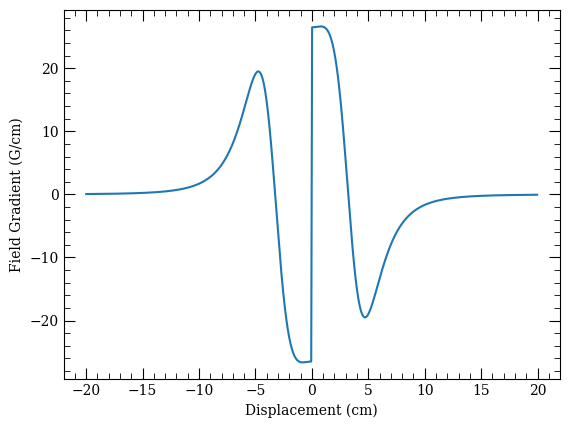

In [13]:
x_displacements = np.linspace(-20,20,1000)*1e-2
xspacing = x_displacements[1] - x_displacements[0]

Br_quad, Bz_quad, Btot_quad = B_antihelmholtz(x_displacements, 0, 34e-3, (56e-3/2), 18, 40)
Btot_mag = np.sqrt((Br_quad)**2 + (Bz_quad)**2)
Btot_diffmax = np.diff(Btot_quad)/(xspacing)

dBdz_vsx = np.array(Btot_diffmax) * 100

plt.plot(x_displacements[0:-1]*1e2, dBdz_vsx)
# plt.plot(x_displacements*1e2, Btot_bias)
plt.xlabel("Displacement (cm)")
plt.ylabel("Field Gradient (G/cm)")


0.02193931022920578
0.062
0.02193931022920578


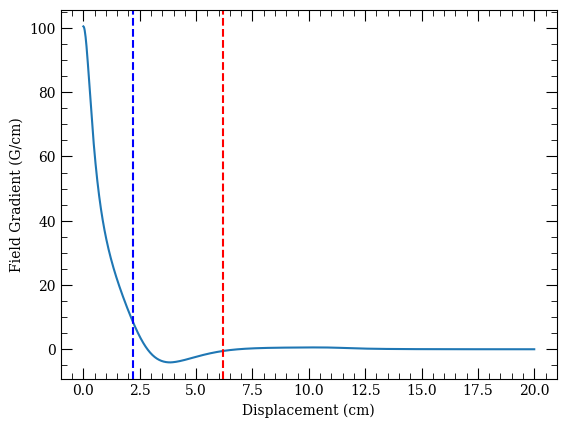

In [61]:
# Atom choice
atom = arc.Caesium()   # pick an atom
n = 6
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 3 # Choose F=1 manifold

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF = lande_gF(F, J, I, gJ, gI)


x_displacements = np.linspace(0,20,1000)*1e-2
z_displacements = np.linspace(-150e-6,150e-6,1000)
zspacing = z_displacements[1]-z_displacements[0]
# xspacing = x_displacements[1]-x_displacements[0]
print(R_quad)
dBdz_vsx = []
for x in x_displacements:
    Br_quad, Bz_quad, Btot_quad = B_antihelmholtz(x, z_displacements, R_quad, s_quad, N_quad, current_quad)
    Br_bias, Bz_bias, Btot_bias = B_helmholtz(x, z_displacements, R_bias, s_bias, N_bias, current_bias)
    Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
    Btot_diffmax = np.max(np.diff(Btot_mag)/(zspacing))
    dBdz_vsx.append(Btot_diffmax)

dBdz_vsx = np.array(dBdz_vsx) * 100

plt.plot(x_displacements*1e2, dBdz_vsx)
# plt.plot(x_displacements*1e2, Btot_bias)
plt.xlabel("Displacement (cm)")
plt.ylabel("Field Gradient (G/cm)")
plt.axvline(R_bias*1e2, color='r', linestyle='--')
plt.axvline(R_quad*1e2, color='b', linestyle='--')
    
print(R_bias)
print(R_quad)

## Transport

In [63]:
#### Fixed variables
power = 18  # power in Watts
wavelength = 1064e-9
alpha_Cs_SI = get_polarizability(wavelength*1e9, "Cs") * a0**3 * 4*np.pi * epsilon_0
alpha_Rb_SI = get_polarizability(wavelength*1e9, "Rb") * a0**3 * 4*np.pi * epsilon_0

# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 10)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 10)  # beam waist from 100 to 300 microns

focus1 = start_pos + 0.072
focus2 = stop_pos - 0.072
waist = 195e-6
Cesium = arc.Caesium   # pick an atom
Rubidium = arc.Rubidium87

# MOT coil parameters, copying 2.0's numbers
N = 18 # 18 turns total
R = 68.326e-3/2 # Inner radius
current = 48 #  A
s = 53e-3/2 # 53 mm between coils along coil axis
bias = -0.0008 # move quadrupole zero field by 1cm

# Rb87
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 1 # Choose F=1 manifold
mF_Rb = 1

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF_Rb = lande_gF(F, J, I, gJ, gI)

# Atom choice
atom = arc.Caesium()   # pick an atom
n = 6
L = 0
J = 1/2
S = 1/2  # For alkali atoms
I  = atom.I # nuclear spin
F = 3 # Choose F=1 manifold
mF_Cs = 3

# Calculated constants
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gF_Cs = lande_gF(F, J, I, gJ, gI)

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

In [64]:
### Mostly copied from Santi's far-detuned lattice transport
def odt_depth(I, alpha):
    """ calculate ODT depth in Kelvin"""
    U = -0.5 * alpha * I / (c * epsilon_0)  # in Joules
    return -U / kB

def Gaussian_beam_size(w0, x, xf, xR):
    """ calculate Gaussian beam size at position x"""
    w_x = w0 * np.sqrt(1 + ((x - xf)/ xR)**2)
    # # plot beam size as a function of distance from focus
    # plt.figure()
    # plt.plot(x - xf, w_x, 'k-', label='Beam Size')
    # plt.xlabel('Distance from Focus (m)')
    # plt.ylabel('Beam Size (m)')
    # plt.axvline(x=0, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return w_x

def Gaussian_beam_peak_intensity(P, w, xf, x):
    """ calculate Gaussian beam peak intensity with beam size w"""
    intensity = 2 * P / (np.pi * w**2) # peak intensity
    # # plot intensity profile
    # plt.figure()
    # plt.plot(x, intensity, 'k-', label='Intensity Profile')
    # plt.xlabel('Position (m)')
    # plt.ylabel('Intensity (W/m^2)')
    # plt.axvline(x=xf, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return intensity

def Gaussian_beam_intensity(P, w0, pos_array, xf, wavelength):
    """ calculate Gaussian beam intensity as a function of x,y,z focused at a point xf"""
    xR = np.pi * w0**2 / wavelength  # Rayleigh range
    w_x = Gaussian_beam_size(w0, pos_array[0], xf, xR) # position dependent beam size
    I_xyz = Gaussian_beam_peak_intensity(P, w_x, xf, pos_array[0]) * np.exp(-2 * (pos_array[1]**2 + pos_array[2]**2) / w_x**2)
    return I_xyz

def two_beam_lattice_intensity(P, w0, pos_array, focus1, focus2, wavelength):
    """ calculate two-beam lattice intensity as a function of x,y,z"""
    I1 = Gaussian_beam_intensity(P, w0, pos_array, focus1)
    I2 = Gaussian_beam_intensity(P, w0, pos_array, focus2)
    I_lattice = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(4 * np.pi * pos_array[0] / wavelength)
    return I_lattice

def radial_trap_depth_vs_x_with_gravity(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    z_max=600e-6, Nz=4001, g=9.80665,
    z_ref=0.0, plot_vertical_pot=False
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # helper: find local min closest to center index using derivative sign change
    def center_local_min_index(y):
        dy = np.diff(y)
        mins = np.where((dy[:-1] < 0) & (dy[1:] > 0))[0] + 1
        if len(mins) == 0:
            return None
        c = len(y) // 2
        return mins[np.argmin(np.abs(mins - c))]

    # helper: find nearest local max on downhill side (gravity pulls toward -z)
    def downhill_local_max_index(y, i_min):
        dy = np.diff(y)
        maxs = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1
        # downhill side is toward negative z, i.e. indices < i_min
        maxs = maxs[maxs < i_min]
        if len(maxs) == 0:
            return None
        return maxs[np.argmax(maxs)]  # closest max below the minimum

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped

    # optional debug plot at center x position
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at center x along z direction
        center_ix = len(x_array) // 2
        pos = np.array([np.full_like(z, x_array[center_ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        Utot = Uopt_uK + Ug_uK
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.axvline(z_min[center_ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[center_ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[center_ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title('Gravity-Adjusted Potential at Center x Position')
        plt.legend()
        plt.show()
    return depth_uK, z_min, Umin_uK, Ubar_uK

In [65]:
### Functions to actual find minima. 
# helper: find local min closest to center index using derivative sign change
def center_local_min_index(y):
    dy = np.diff(y)
    mins = np.where((dy[:-1] < 0) & (dy[1:] > 0))[0] + 1
    if len(mins) == 0:
        return None
    c = len(y) // 2
    return mins[np.argmin(np.abs(mins - c))]  

# helper: find nearest local max on downhill side (gravity pulls toward -z)
def downhill_local_max_index(y, i_min):
    dy = np.diff(y)
    maxs = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1
    if y[0]>y[-1]:
        maxs = maxs[maxs > i_min]
    if y[0]<y[-1]:
        maxs = maxs[maxs < i_min]
    if len(maxs) == 0:
        return None
    return maxs[np.argmax(maxs)]  # closest max below the minimum

def radial_trap_depth_vs_x_with_gravity_and_maglev(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    R_quad, s_quad, N_quad, current_quad,
    R_bias, s_bias, N_bias, current_bias,
    gF, mF,
    z_max=600e-6, Nz=4001, g=9.80665,
    z_ref=0.0, plot_vertical_pot=False, x_pos=0
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        
        # magnetic potential energy in uK
        Br_quad, Bz_quad, _ = B_antihelmholtz(x, z, R_quad, s_quad, N_quad, current_quad)
        Br_bias, Bz_bias, _ = B_helmholtz(x, z, R_bias, s_bias, N_bias, current_bias)
        Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
        _, Umag = U_from_mag(gF, mF, Btot_mag)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped
      # optional debug plot at center x position
      
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at x_position along z direction
        ix = x_pos
        pos = np.array([np.full_like(z, x_array[ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1, wavelength)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2, wavelength)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # magnetic potential energy in uK
        Br_quad, Bz_quad, _ = B_antihelmholtz(x_array[ix], z, R_quad, s_quad, N_quad, current_quad)
        Br_bias, Bz_bias, _ = B_helmholtz(x_array[ix], z, R_bias, s_bias, N_bias, current_bias)
        Btot_mag = np.sqrt((Br_quad+Br_bias)**2 + (Bz_quad+Bz_bias)**2)
        _, Umag = U_from_mag(gF, mF, Btot_mag)
        Umag_uK = Umag*1e6
        Umag_normalized = Umag_uK - np.average(Umag_uK)
        
        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK + Umag_normalized

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            i_min = 0

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            i_bar = 0
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            
        Ubar_uK[ix] = Utot[i_bar]
        
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity + Maglev')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.plot(z, Umag_normalized, 'r--', label='Mag potential slope')
        plt.plot(z, Ug_uK, 'g--', label='Grav Potential')
        plt.axvline(z_min[ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title(f'Gravity+Maglev-Adjusted Potential Energy at x = {x_array[ix]}')
        plt.legend()
        plt.show()

    return depth_uK, z_min, Umin_uK, Ubar_uK

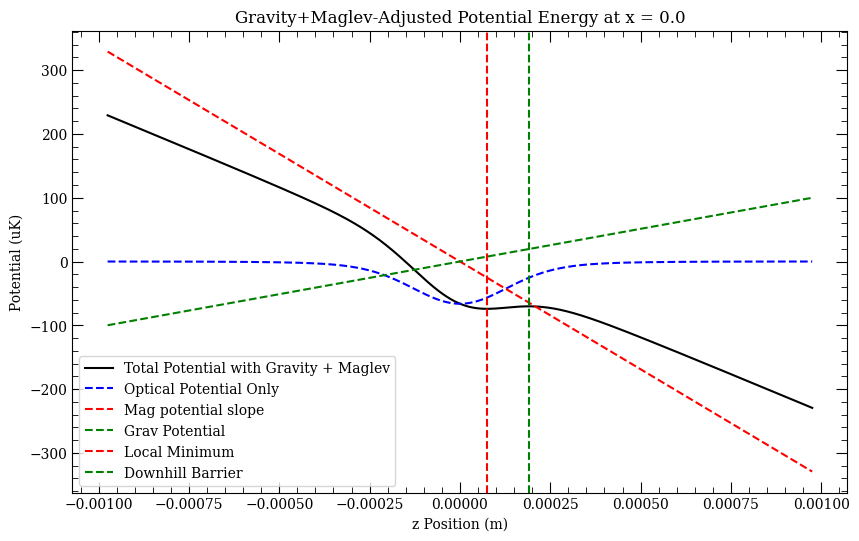

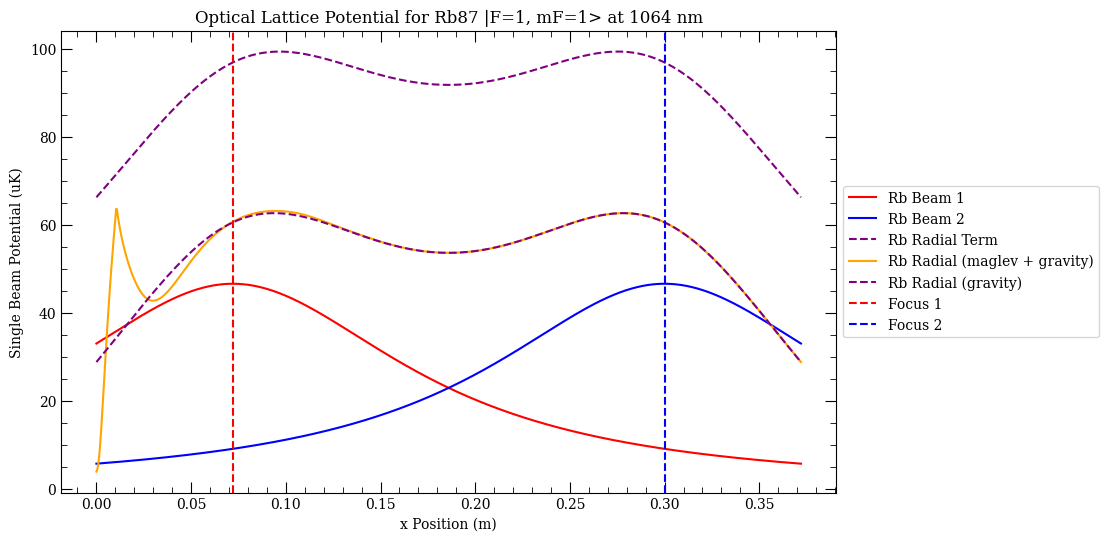

In [66]:
###### RB Calculations
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity_and_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=Rubidium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, current_quad=current_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, current_bias=current_bias,
    gF=gF_Rb, mF=mF_Rb,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True, x_pos=0
)
grav_depth_Rb_uK, grav_zmin_Rb, grav_Umin_Rb, grav_Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=Rubidium().mass,
    z_max=5*waist, Nz=1000
)
plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', linestyle='--', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK, 'orange', linestyle='-', label='Rb Radial (maglev + gravity)')
plt.plot(pos_array[0], grav_depth_Rb_uK, 'purple', linestyle='--', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('x Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb87 |F=1, mF=1> at 1064 nm')
plt.show()

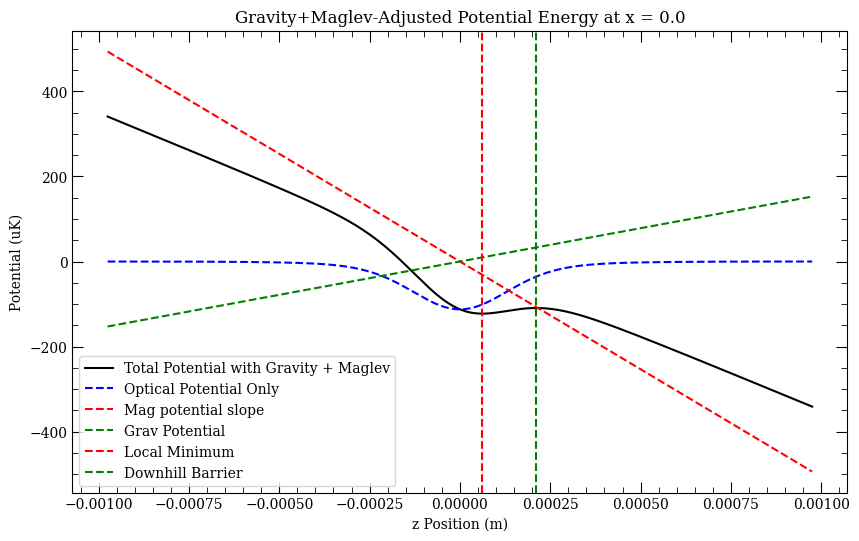

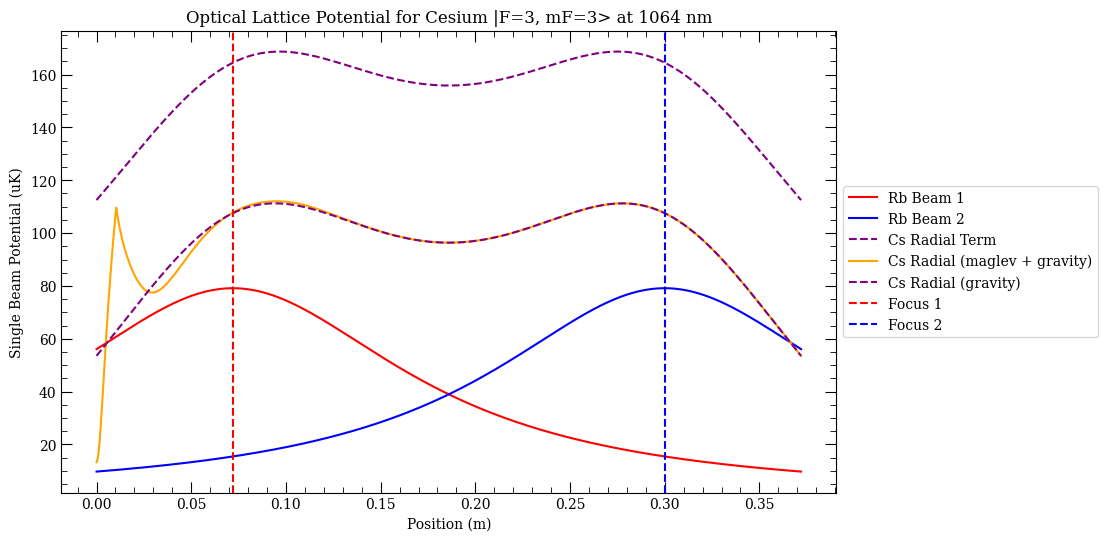

In [67]:
###### Cs Calculations
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK

depth_Cs_uK, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity_and_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=arc.Caesium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, current_quad=current_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, current_bias=current_bias,
    gF=gF_Cs, mF=mF_Cs,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True, x_pos=0
)
grav_depth_Cs_uK, grav_zmin_Cs, grav_Umin_Cs, grav_Ubar_Cs = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=arc.Caesium().mass,
    z_max=5*waist, Nz=1000
)
plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Cs, 'purple', linestyle='--', label='Cs Radial Term')
plt.plot(pos_array[0], depth_Cs_uK, 'orange', linestyle='-', label= 'Cs Radial (maglev + gravity)')
plt.plot(pos_array[0], grav_depth_Cs_uK, 'purple', linestyle='--', label='Cs Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Cesium |F=3, mF=3> at 1064 nm')
plt.show()

In [53]:
# now 2D sweep of beam waist and beam focus positions w/ maglev + gravity accounted for

#### Fixed variables
power = 18  # power in Watts
wavelength = 1064e-9
alpha_Cs_SI = get_polarizability(wavelength*1e9, "Cs") * a0**3 * 4*np.pi * epsilon_0
alpha_Rb_SI = get_polarizability(wavelength*1e9, "Rb") * a0**3 * 4*np.pi * epsilon_0

# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 100)  # focus positions from 0 to center position

waist_array = np.linspace(50e-6, 300e-6, 100)  # beam waist from 100 to 300 microns

# for the sweep, we find the minimum radial trap depth between the start and stop positions
min_trap_depth_Cs = []
min_trap_depth_Rb = []

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

for waist in tqdm(waist_array):
    temp_depths_Cs = []
    temp_depths_Rb = []
    for focus in focus_array:
        # calculate the intensity for each beam
        depth_Cs_uK, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity_and_maglev(
            x_array=pos_array[0],
            P=power, w0=waist,
            focus1=focus1, focus2=focus2,
            wavelength=wavelength,
            alpha_SI=alpha_Cs_SI,
            mass_kg=arc.Caesium().mass,
            R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, current_quad=current_quad,
            R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, current_bias=current_bias,
            gF=gF_Cs, mF=mF_Cs,
            z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=0
        )

        depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity_and_maglev(
            x_array=pos_array[0],
            P=power, w0=waist,
            focus1=focus1, focus2=focus2,
            wavelength=wavelength,
            alpha_SI=alpha_Rb_SI,
            mass_kg=Rubidium().mass,
            R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, current_quad=current_quad,
            R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, current_bias=current_bias,
            gF=gF_Rb, mF=mF_Rb,
            z_max=5*waist, Nz=1000, plot_vertical_pot=False, x_pos=0)
        
        temp_depths_Cs.append(depth_Cs_uK)
        temp_depths_Rb.append(depth_Rb_uK)

    # find the minimum trap depth
    min_trap_depth_Cs.append(temp_depths_Cs)
    min_trap_depth_Rb.append(temp_depths_Rb)

# find the optimal parameters for maximum trap depth from above data
min_trap_depth_Cs = np.array(min_trap_depth_Cs)
min_trap_depth_Rb = np.array(min_trap_depth_Rb)

opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")

# plot the results as a heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(min_trap_depth_Cs, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Cs at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Cs[1]], waist_array[opt_params_Cs[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(min_trap_depth_Rb, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Rb at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Rb[1]], waist_array[opt_params_Rb[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
focus1 = start_pos + 0.0207
focus2 = stop_pos - 0.0207
waist = 75.69e-6
I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength)
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
bias = -0.01
depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity_and_maglev(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=Rubidium().mass,
    R_quad=R_quad, s_quad=s_quad, N_quad=N_quad, current_quad=current_quad,
    R_bias=R_bias, s_bias=s_bias, N_bias=N_bias, current_bias=current_bias,
    gF=gF, mF=1,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True, x_pos=100
)
plt.figure(figsize=(10, 6))
# plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
# plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
# plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK, 'orange', linestyle='--', label='Rb Radial (maglev + gravity)')
# plt.plot(pos_array[0], grav_depth_Rb_uK, 'purple', linestyle='--', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb at 1064 nm')
plt.show()